In [2]:
import duckdb
db = duckdb.connect() # No need to pass a file name, we will use a VIEW
# only keep the first 10000 rows of the database
# db.execute("CREATE VIEW votes AS SELECT * FROM parquet_scan('parquets/votes_decimal128.parquet') LIMIT 10000")
db.execute("CREATE VIEW votes AS SELECT * FROM parquet_scan('parquets/votes_decimal128.parquet')")
db.execute("select count(*) from votes").fetchall()

[(21867988,)]

In [3]:
# show the schema
db.execute("SELECT * FROM votes LIMIT 1").description

[('platform', 'STRING', None, None, None, None, None),
 ('platform_deployment_id', 'STRING', None, None, None, None, None),
 ('proposal_id', 'STRING', None, None, None, None, None),
 ('vote_id', 'STRING', None, None, None, None, None),
 ('voter', 'STRING', None, None, None, None, None),
 ('date', 'DATETIME', None, None, None, None, None),
 ('choice', 'STRING', None, None, None, None, None),
 ('weight', 'NUMBER', None, None, None, None, None)]

In [8]:
# group by (platform, platform_deployment_id, voter) and get the median of weight (named effective_vp)
voting_power_df = db.execute("""
                          SELECT platform, platform_deployment_id, voter, percentile_cont(0.5)
                          WITHIN GROUP (ORDER BY weight)
                          FROM votes
                          GROUP BY platform, platform_deployment_id, voter
""").fetchdf()
voting_power_df.columns = ['platform', 'platform_deployment_id', 'voter', 'effective_vp']
voting_power_df.head()

,platform,platform_deployment_id,voter,effective_vp
0,realms,84pGFuy1Y27ApK67ApethaPvexeDWA66zNV8gm38TVeQ,568F8CYYDE9BuKPqw5MzYFqwafDSWagPQMz8XQi19RXq,1.0
1,realms,84pGFuy1Y27ApK67ApethaPvexeDWA66zNV8gm38TVeQ,DaSiWEEj3bWiqf8KVLPQ3ant1RCZgd93dtQfMc9ReovH,1.0
2,realms,12gEDQvesi9qSMoXcY1LSHxGqArUXZ2HemihyEShpoWf,MARker5J6S5yKCb2hT5RfvxbpQSc6CCXGeZo7xecZwK,1.0
3,realms,12gEDQvesi9qSMoXcY1LSHxGqArUXZ2HemihyEShpoWf,6SGeRWrXHX27SMASc7UNFPmNSrww3dieLQyjdzpiL4mD,1.0
4,realms,12gEDQvesi9qSMoXcY1LSHxGqArUXZ2HemihyEShpoWf,C557tfC74zRUUkC2LJoXz8KuRb7oenf62g8VxNeMrEhJ,1.0


In [9]:
import pandas as pd
import numpy as np

# sort voting_power_df by platform, platform_deployment_id, and then effective_vp
voting_power_df = voting_power_df.sort_values(by=['platform', 'platform_deployment_id', 'effective_vp'])
# add the rank column
voting_power_df['rank'] = voting_power_df.groupby(['platform', 'platform_deployment_id'])['effective_vp'].rank(method='first', ascending=False)

voting_power_df['rank_by_weight'] = voting_power_df['rank'] * voting_power_df['effective_vp']

# def gini_coefficient(x):
#     x = sorted(x)
#     n = len(x)
#     s = sum(x)
#     d = n * s
#     G = sum(xi * (n - i) for i, xi in enumerate(x))
#     return (d + s - 2 * G) / d
#     return ((n*s) + s - 2 * G) / (n*s)
#  n=number of voters
#  s=sum of all weights
#  G=sum of all rank_by_weight values

# do the group by
voting_power_df = voting_power_df.groupby(['platform', 'platform_deployment_id']).agg(
    n=('voter', 'count'),
    s=('effective_vp', 'sum'),
    G=('rank_by_weight', 'sum')
).reset_index()

voting_power_df['d'] = voting_power_df['n'] * voting_power_df['s']

voting_power_df['gini'] = (voting_power_df['d'] + voting_power_df['s'] - 2 * voting_power_df['G']) / voting_power_df['d']

voting_power_df.head()

,platform,platform_deployment_id,n,s,G,d,gini
0,aragon,0x0017a25385931ee690dc09df6cca919d1cd007b2,1,1.000000e+18,1.000000e+18,1.000000e+18,0.000000
1,aragon,0x001cd74c9a99b6c68e93fe69595124407b37aa8e,59,2.812068e+23,4.289201e+24,1.659120e+25,0.499904
2,aragon,0x00ccb72bd1f72882d89774d9acccce616ed9227d,3,8.999800e+22,1.799950e+23,2.699940e+23,0.000007
3,aragon,0x0163c547b4abd1672e213291cc62582c357868fe,5,1.264943e+20,1.264943e+20,6.324717e+20,0.800000
4,aragon,0x016f8665ac8b24a245cddb73dcf27439f1879a40,1,1.000000e+00,1.000000e+00,1.000000e+00,0.000000


In [11]:
voting_power_df.shape

(16742, 7)

<Axes: >

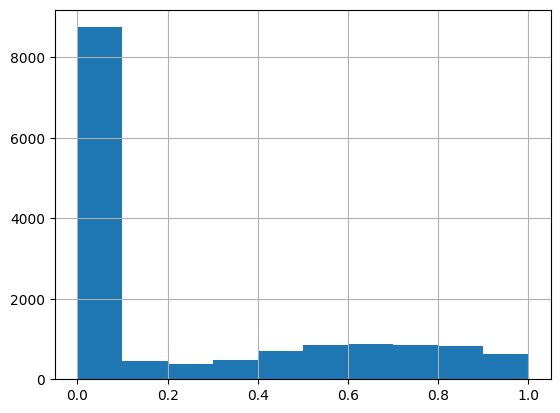

In [10]:
voting_power_df['gini'].hist()

<Axes: >

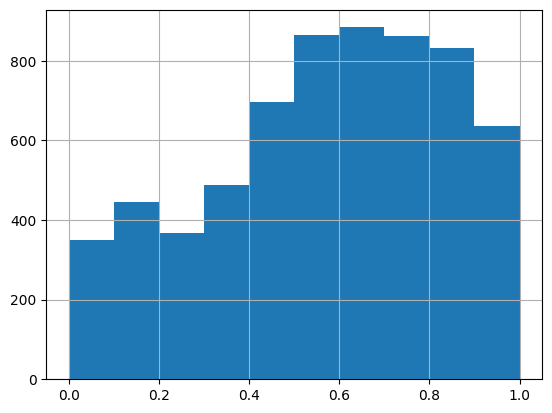

In [12]:
# hist and ignore the 0.0 values
voting_power_df[voting_power_df['gini'] > 0.0]['gini'].hist()

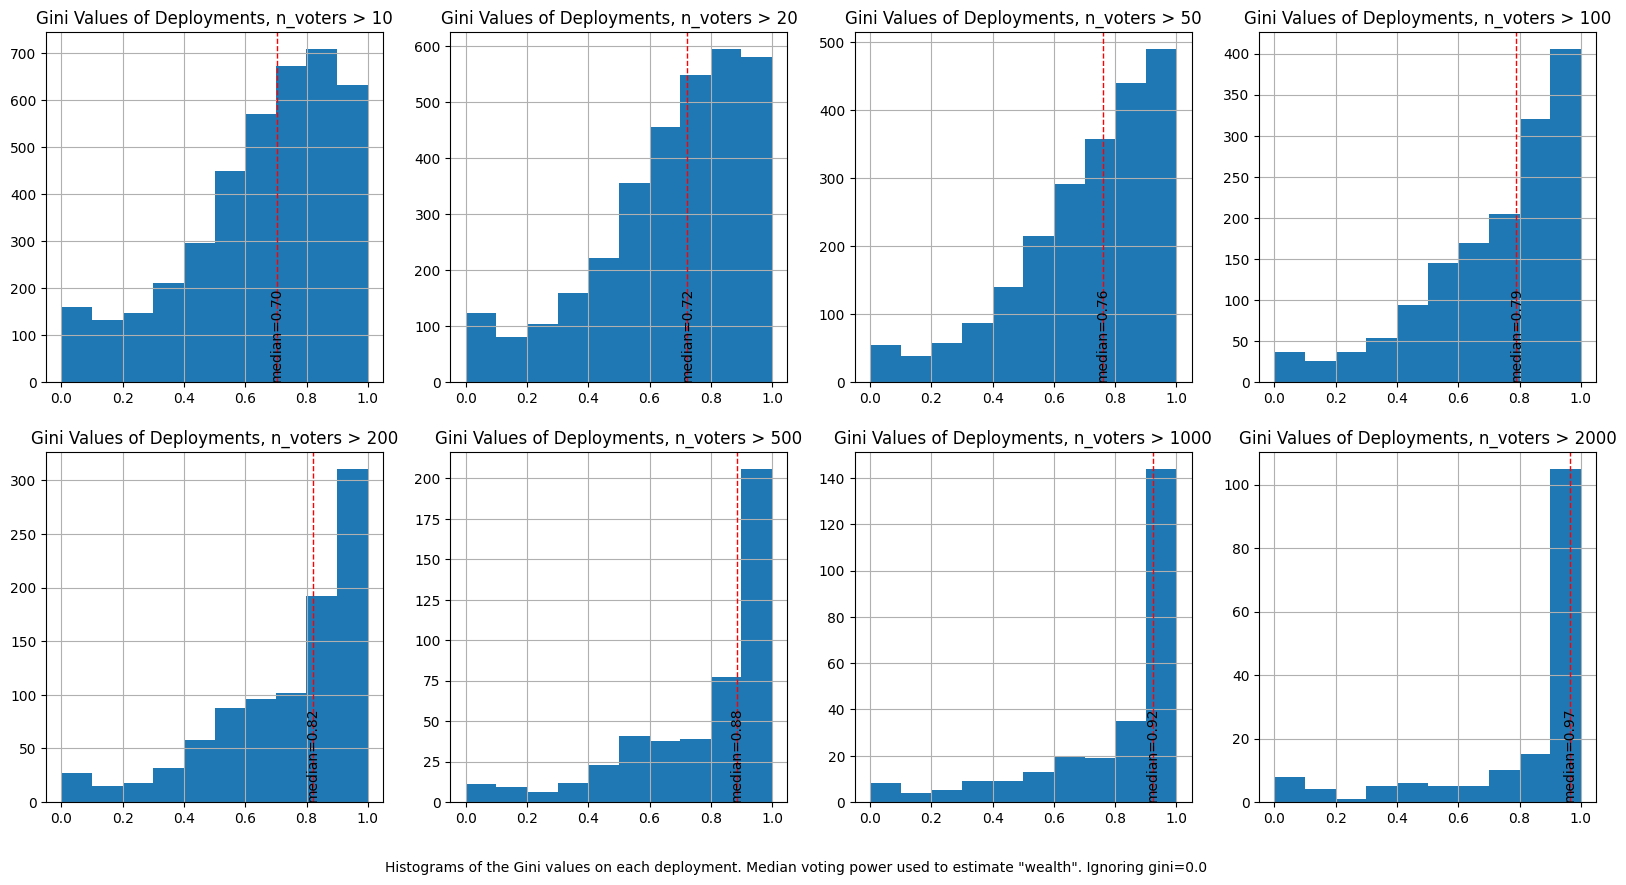

In [40]:
import matplotlib.pyplot as plt
# make a grid of 8 plots, each plots the histogram of gini values where n is greater than a given value in values
values = [10, 20, 50, 100, 200, 500, 1000, 2000]
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
for i, ax in enumerate(axs.flatten()):
    ax.set_title(f'Gini Values of Deployments, n_voters > {values[i]}')
    voting_power_df[(voting_power_df['gini'] > 0.0) & (voting_power_df['n'] > values[i])]['gini'].hist(ax=ax)
    # add median line
    ax.axvline(voting_power_df[(voting_power_df['gini'] > 0.0) & (voting_power_df['n'] > values[i])]['gini'].median(), color='red', linestyle='dashed', linewidth=1)
    # label with median value
    ax.text(voting_power_df[(voting_power_df['gini'] > 0.0) & (voting_power_df['n'] > values[i])]['gini'].median(), 0, f"median={voting_power_df[(voting_power_df['gini'] > 0.0) & (voting_power_df['n'] > values[i])]['gini'].median():.2f}", rotation=90, va='bottom', ha='center', color='black')
# add a label that ignoring gini=0.0
_ = fig.text(0.5, 0.04, 'Histograms of the Gini values on each deployment. Median voting power used to estimate "wealth". Ignoring gini=0.0', ha='center')